# Model Comparison and Results

This notebook compares the performance and size of all CIFAR-10 models trained in previous notebooks:
- **01-DNN**: Fully connected deep neural network
- **02-CNN**: Convolutional neural network (grayscale)
- **03-RGB-CNN**: Convolutional neural network (RGB)
- **04-optimized-CNN**: Hyperparameter-optimized CNN
- **05-augmented-CNN**: CNN trained with data augmentation

## Notebook Setup

### Imports

In [1]:
# Standard library imports
import pickle
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Package imports
from image_classification_tools.pytorch.plotting import (
    plot_confusion_matrix
)

### Configuration

In [2]:
# Set random seeds for reproducibility
np.random.seed(315)

# Paths
results_dir = Path('../data/pytorch/performance_results')

# CIFAR-10 class names
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

## 1. Load Saved Test Results

Load the test results saved from each notebook instead of re-running the models.

In [3]:
# Model configurations with result file paths
models_config = [
    {
        'name': 'DNN',
        'results_path': results_dir / 'dnn_results.pkl',
        'description': 'Fully connected neural network'
    },
    {
        'name': 'CNN (Grayscale)',
        'results_path': results_dir / 'cnn_results.pkl',
        'description': 'CNN on grayscale images'
    },
    {
        'name': 'RGB CNN',
        'results_path': results_dir / 'rgb_cnn_results.pkl',
        'description': 'CNN on RGB images'
    },
    {
        'name': 'Optimized CNN',
        'results_path': results_dir / 'optimized_cnn_results.pkl',
        'description': 'Hyperparameter-tuned CNN'
    },
    {
        'name': 'Augmented CNN',
        'results_path': results_dir / 'augmented_cnn_results.pkl',
        'description': 'CNN with data augmentation'
    }
]

results = []

for config in models_config:
    
    # Check if results file exists
    if not config['results_path'].exists():
        
        print(f"Skipping {config['name']}")
        continue
    
    # Load saved results
    try:
        with open(config['results_path'], 'rb') as f:
            data = pickle.load(f)
        
        true_labels = np.array(data['true_labels'])
        predictions = np.array(data['predictions'])
        all_probs = np.array(data['all_probs'])
        test_accuracy = float(data['test_accuracy'])
        total_params = int(data['total_params'])
        trainable_params = int(data['trainable_params'])
        
        # Calculate model size (approximate based on parameters)
        # Assuming float32 (4 bytes per parameter)
        model_size_mb = (total_params * 4) / (1024 ** 2)
        
        # Store results
        results.append({
            'Model': config['name'],
            'Description': config['description'],
            'Total Parameters': total_params,
            'Trainable Parameters': trainable_params,
            'Size (MB)': model_size_mb,
            'Test Accuracy (%)': test_accuracy,
            'true_labels': true_labels,
            'predictions': predictions,
            'all_probs': all_probs
        })
        
    except Exception as e:
        print(f"Error loading results: {e}")
        continue

## 2. Results Summary

In [4]:
# Create summary dataframe
summary_df = pd.DataFrame([
    {
        'Model': r['Model'],
        'Description': r['Description'],
        'Parameters': f"{r['Total Parameters']:,}",
        'Size (MB)': f"{r['Size (MB)']:.2f}",
        'Accuracy (%)': f"{r['Test Accuracy (%)']:.2f}"
    }
    for r in results
])

summary_df.head()

,Model,Description,Parameters,Size (MB),Accuracy (%)
0,DNN,Fully connected neural network,"1,329,098",5.07,48.83
1,CNN (Grayscale),CNN on grayscale images,"15,210",0.06,62.99
2,RGB CNN,CNN on RGB images,"15,786",0.06,68.07
3,Optimized CNN,Hyperparameter-tuned CNN,"4,889,322",18.65,82.08
4,Augmented CNN,CNN with data augmentation,"4,889,322",18.65,76.40


## 3. Performance Visualizations

### Model Size vs Accuracy

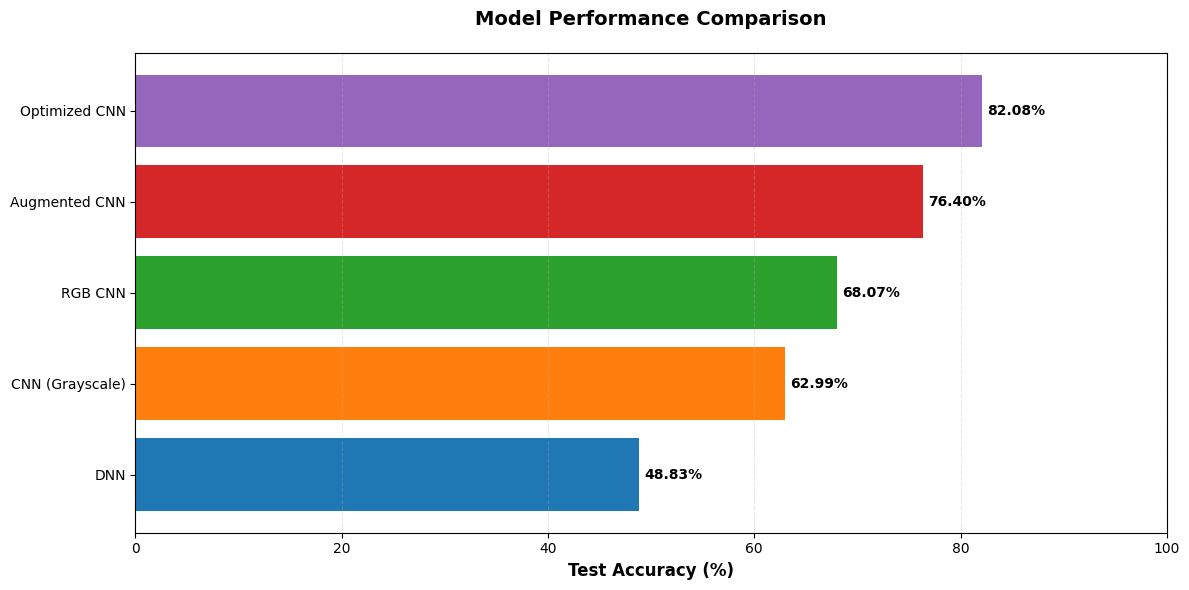

In [5]:
# Sort by accuracy for better visualization
sorted_results = sorted(results, key=lambda x: x['Test Accuracy (%)'])

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))

models = [r['Model'] for r in sorted_results]
accuracies = [r['Test Accuracy (%)'] for r in sorted_results]

bars = ax.barh(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    ax.text(acc + 0.5, i, f'{acc:.2f}%', va='center', fontweight='bold')

ax.set_xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### Efficiency Metric

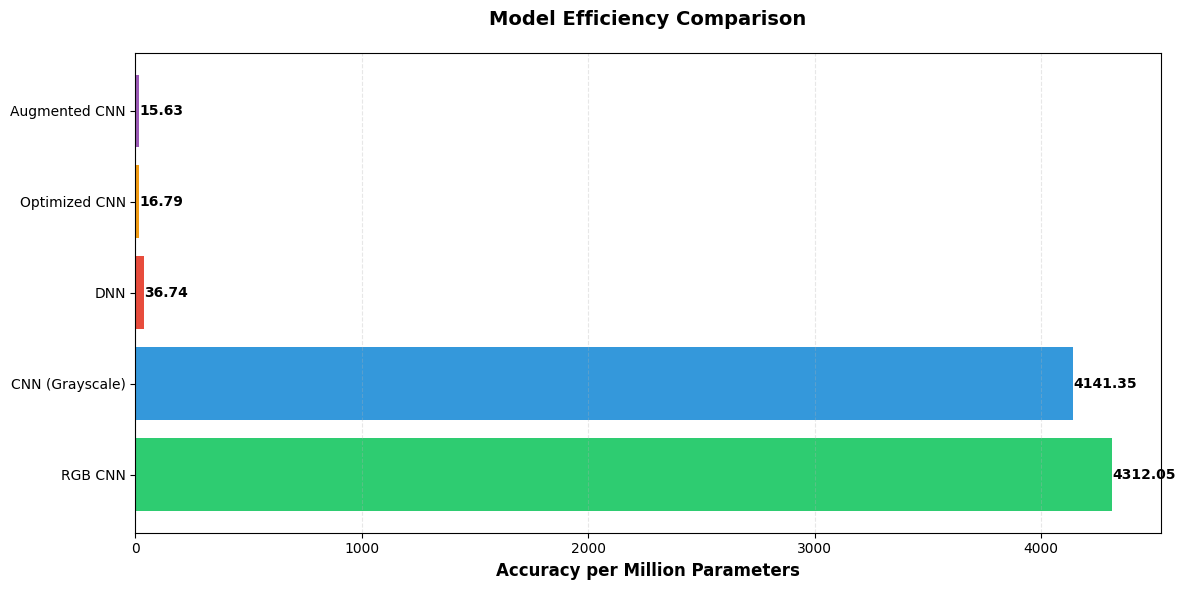


Efficiency Rankings (Accuracy per Million Parameters):
1. RGB CNN: 4312.05
2. CNN (Grayscale): 4141.35
3. DNN: 36.74
4. Optimized CNN: 16.79
5. Augmented CNN: 15.63


In [6]:
# Calculate efficiency metric
efficiency_results = []
for r in results:
    params_millions = r['Total Parameters'] / 1e6
    efficiency = r['Test Accuracy (%)'] / params_millions
    efficiency_results.append({
        'Model': r['Model'],
        'Accuracy/Param (M)': efficiency
    })

# Sort by efficiency
efficiency_results = sorted(efficiency_results, key=lambda x: x['Accuracy/Param (M)'], reverse=True)

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))

models = [r['Model'] for r in efficiency_results]
efficiencies = [r['Accuracy/Param (M)'] for r in efficiency_results]

bars = ax.barh(models, efficiencies, color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12', '#9b59b6'])

# Add value labels
for i, (bar, eff) in enumerate(zip(bars, efficiencies)):
    ax.text(eff + 0.5, i, f'{eff:.2f}', va='center', fontweight='bold')

ax.set_xlabel('Accuracy per Million Parameters', fontsize=12, fontweight='bold')
ax.set_title('Model Efficiency Comparison', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Print efficiency table
print("\nEfficiency Rankings (Accuracy per Million Parameters):")
print("="*60)
for i, r in enumerate(efficiency_results, 1):
    print(f"{i}. {r['Model']}: {r['Accuracy/Param (M)']:.2f}")
print("="*60)

## 4. Per-Class Performance Analysis

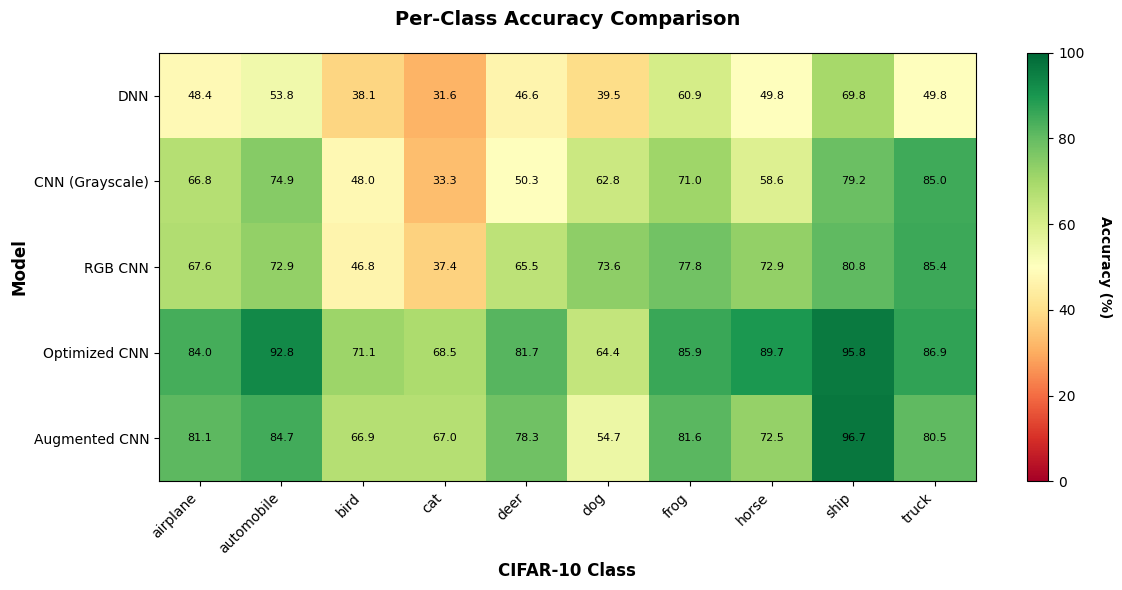


Per-Class Accuracy Summary (%):
             DNN  CNN (Grayscale)  RGB CNN  Optimized CNN  Augmented CNN
airplane    48.4             66.8     67.6           84.0           81.1
automobile  53.8             74.9     72.9           92.8           84.7
bird        38.1             48.0     46.8           71.1           66.9
cat         31.6             33.3     37.4           68.5           67.0
deer        46.6             50.3     65.5           81.7           78.3
dog         39.5             62.8     73.6           64.4           54.7
frog        60.9             71.0     77.8           85.9           81.6
horse       49.8             58.6     72.9           89.7           72.5
ship        69.8             79.2     80.8           95.8           96.7
truck       49.8             85.0     85.4           86.9           80.5


In [7]:
# Calculate per-class accuracy for each model
class_accuracies = {}

for r in results:
    true = r['true_labels']
    pred = r['predictions']
    
    # Calculate accuracy for each class
    class_acc = []
    for i in range(10):
        mask = (true == i)
        if mask.sum() > 0:
            acc = (pred[mask] == i).sum() / mask.sum() * 100
            class_acc.append(acc)
        else:
            class_acc.append(0)
    
    class_accuracies[r['Model']] = class_acc

# Create dataframe for better visualization
class_acc_df = pd.DataFrame(class_accuracies, index=class_names)

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 6))

# Plot heatmap
im = ax.imshow(class_acc_df.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

# Set ticks and labels
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(results)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels([r['Model'] for r in results])

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Accuracy (%)', rotation=270, labelpad=20, fontweight='bold')

# Add text annotations
for i in range(len(results)):
    for j in range(len(class_names)):
        text = ax.text(j, i, f'{class_acc_df.iloc[j, i]:.1f}',
                      ha="center", va="center", color="black", fontsize=8)

ax.set_title('Per-Class Accuracy Comparison', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('CIFAR-10 Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary
print("\nPer-Class Accuracy Summary (%):")
print("="*80)
print(class_acc_df.round(1))
print("="*80)

## 5. Confusion Matrix Comparison

Worst Model: DNN - Accuracy: 48.83%


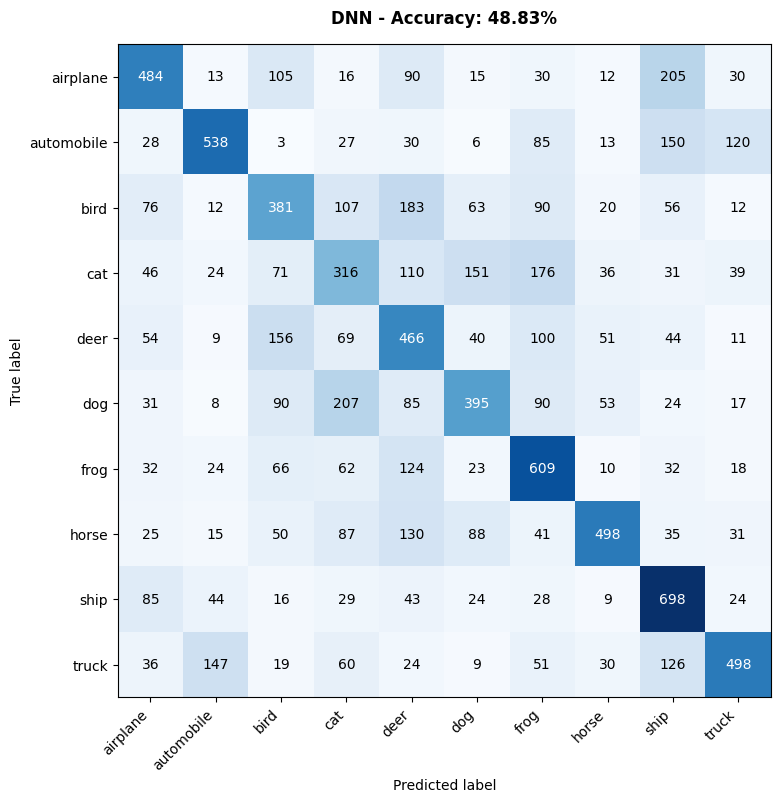


Best Model: Optimized CNN - Accuracy: 82.08%


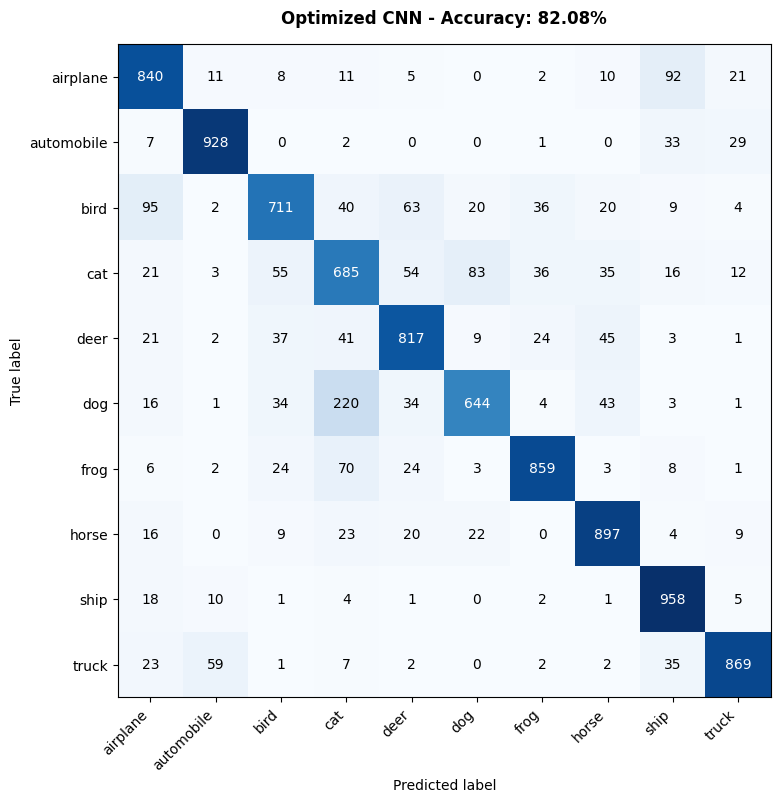

In [8]:
# Find best and worst models by accuracy
sorted_by_acc = sorted(results, key=lambda x: x['Test Accuracy (%)'])
worst_model = sorted_by_acc[0]
best_model = sorted_by_acc[-1]

# Plot confusion matrix for worst model
print(f"Worst Model: {worst_model['Model']} - Accuracy: {worst_model['Test Accuracy (%)']:.2f}%")
fig1, ax1 = plot_confusion_matrix(
    worst_model['true_labels'], 
    worst_model['predictions'], 
    class_names,
    figsize=(8, 8)
)
ax1.set_title(f'{worst_model["Model"]} - Accuracy: {worst_model["Test Accuracy (%)"]:.2f}%', 
              fontsize=12, fontweight='bold', pad=15)
plt.show()

# Plot confusion matrix for best model
print(f"\nBest Model: {best_model['Model']} - Accuracy: {best_model['Test Accuracy (%)']:.2f}%")
fig2, ax2 = plot_confusion_matrix(
    best_model['true_labels'], 
    best_model['predictions'], 
    class_names,
    figsize=(8, 8)
)
ax2.set_title(f'{best_model["Model"]} - Accuracy: {best_model["Test Accuracy (%)"]:.2f}%', 
              fontsize=12, fontweight='bold', pad=15)
plt.show()